## Prelude

In [184]:
%pip install datasets
%pip install matplotlib
%pip install piecewise-regression

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 9.1 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [219]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import os
import json
import piecewise_regression

from datasets import load_dataset

from math import exp
import glob

In [3]:
SEED = 42

### GSM8K-specific

In [ ]:
gsm8k_df = pd.DataFrame(load_dataset("gsm8k", "main")["test"])

### MATH-specific

In [4]:
%pip install git+https://github.com/hendrycks/math.git

  Cloning https://github.com/hendrycks/math.git to /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-p1oqjvvq
  Running command git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-p1oqjvvq
  Resolved https://github.com/hendrycks/math.git to commit 357963a7f5501a6c1708cf3f3fb0cdf525642761
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
from math_equivalence import is_equiv as boxed_answer_is_equiv

## CalibrationDataset and CalibrationRun class defs

In [221]:
class CalibrationDataset:
    def __init__(
        self,
        dataset_name,
        df,
        is_equiv,
        get_value_from_response,
        get_prompt_content,
        get_value_tokens_prob,
        seed,
    ):
        self.dataset_name = dataset_name
        self.df = df
        self.is_equiv = is_equiv
        self.get_value_from_response = get_value_from_response
        self.get_prompt_content = get_prompt_content
        self.get_value_tokens_prob = get_value_tokens_prob
        self.seed = seed

        self.df['q_id'] = self.df.index

    def get_examples_text(self, num_shots):
        return "\n\n".join(
            self.df.sample(num_shots, random_state=self.seed)
            .apply(lambda row: f"Question: {row['question']}\n\nAnswer: {row['answer']}", axis=1)
        )

In [259]:
class CalibrationRun:
    def __init__(
        self,
        dataset,
        model_name,
        num_questions,
        num_attempts_per_question,
        num_shots,
        max_response_tokens,
        requests_file_path,
        results_file_pattern,
    ):
        self.dataset = dataset
        self.model_name = model_name
        self.num_questions = num_questions
        self.num_attempts_per_question = num_attempts_per_question
        self.num_shots = num_shots
        self.max_response_tokens = max_response_tokens
        self.requests_file_path = requests_file_path
        self.results_file_pattern = results_file_pattern
        self.results = None

    def write_requests_file(self):
        df = self.dataset.df.sample(self.num_questions, random_state=self.dataset.seed).copy()

        att = pd.concat([df]*self.num_attempts_per_question, ignore_index=True)
        with open(self.requests_file_path, "w") as f:
            for index, row in att.iterrows():
                dict_for_one_request = {
                    "custom_id": f"request_{index}_qid_{row.q_id}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": self.model_name,
                        "messages": [
                            {"role": "system", "content": "You are a helpful assistant."},
                            {
                                "role": "user",
                                "content": self.dataset.get_prompt_content(
                                    question=row.question,
                                    examples_text=self.dataset.get_examples_text(self.num_shots),
                                )
                            }
                        ],
                        "max_tokens": self.max_response_tokens,
                        "logprobs": True,
                        "top_logprobs": 1,
                    }
                }
                print(json.dumps(dict_for_one_request), file=f)

    def read_results_file(self):
        def parse_json_string(line):
            try:
                return json.loads(line)
            except ValueError:
                return None
        
        lines = []

        for file in glob.glob(self.results_file_pattern):
            with open(file, "r") as f:
                lines.extend([parse_json_string(line.rstrip()) for line in f])
        
        line_count = len(lines)
        lines = [line for line in lines if line is not None]
        lines_dropped = line_count - len(lines)
        print(f"Lines dropped: {lines_dropped}")
        df = pd.DataFrame.from_dict(lines)
        df["q_id"] = df["custom_id"].str.split("_").str[3].astype(int)
        df["attempt"] = df["response"].apply(
            lambda r: r['choices'][0]['message']['content']
        )
        df['attempt_value'] = df['attempt'].apply(self.dataset.get_value_from_response)
        df['value_tokens_prob'] = df['response'].apply(lambda r: self.dataset.get_value_tokens_prob(r['choices'][0]['logprobs']))
        df['all_tokens_logprob'] = df['response'].apply(lambda r: sum(r['choices'][0]['logprobs']['token_logprobs']))

        df = (
            df[['q_id', 'attempt', 'attempt_value', 'value_tokens_prob', 'all_tokens_logprob']]
            .merge(self.dataset.df[['q_id', 'question', 'answer']], how='left', on='q_id')
        )
        df['correct'] = df.progress_apply(lambda row: 1 if self.dataset.is_equiv(row['attempt'], row['answer']) else 0, axis=1)

        self.results = df

    def get_confs(self, confidence_estimator):
        assert self.results is not None, "results not yet parsed"
        if confidence_estimator == "sampled_conf":
            confs = (
                self.results[['q_id', 'attempt_value', 'correct']]
                .assign(sampled_conf=1/self.num_attempts_per_question)
                .groupby(['q_id', 'attempt_value'])
                .aggregate({'sampled_conf': 'sum', 'correct': 'mean'})
                .reset_index()
            )

            idx = confs.groupby('q_id')['sampled_conf'].transform("max") == confs['sampled_conf']
            confs = confs[idx].groupby('q_id').first()

        elif confidence_estimator ==  "value_tokens_prob":
            confs = self.results[['q_id', 'value_tokens_prob', 'correct']]

        elif confidence_estimator ==  "all_tokens_logprob_conf":
            X = self.results[['all_tokens_logprob']].assign(ones=1).to_numpy()
            y = self.results['correct'].to_numpy()
            betas = np.linalg.inv(X.T @ X) @ X.T @ y
            confs = self.results[['q_id', 'correct']].assign(all_tokens_logprob_conf = (X @ betas))

        return confs
    
    def top1_acc(self):
        return self.get_confs(confidence_estimator="sampled_conf")['correct'].mean()
    
    def get_binned(self, confidence_estimator, qa_pairs_per_bin):
        return (
            self.get_confs(confidence_estimator)
            .sort_values(confidence_estimator)
            .reset_index(drop=True)
            .assign(bin=lambda row: row.index // qa_pairs_per_bin)[['bin', confidence_estimator, 'correct']]
            .groupby('bin')
            .mean()
        )

    def plot_estimated_confidence_vs_accuracy(self, confidence_estimator, qa_pairs_per_bin=25):
        binned = self.get_binned(confidence_estimator, qa_pairs_per_bin)
        fig, ax = plt.subplots()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.scatter(binned[confidence_estimator], binned['correct'])
        # ax.plot([0,1],[0,1], transform=ax.transAxes)

        plt.title(f"{self.model_name} calibration\n({self.dataset.dataset_name} {self.num_shots}-shot, {self.num_questions} Qs, {self.num_attempts_per_question} attempts/Q)")
        plt.xlabel(confidence_estimator)
        plt.ylabel('accuracy')

        plt.show()

In [275]:
def cost_acc_curve_points(confidence_estimator, run1, run2, cost1, cost2):
    run1_confs = run1.get_confs(confidence_estimator)
    run2_acc = 0.88

    curve_points = []
    for conf_threshold in np.linspace(0, 1, 100):
        attempts_meeting_conf_threshold = run1_confs[run1_confs[confidence_estimator] >= conf_threshold]
        pct_meeting_conf_threshold = len(attempts_meeting_conf_threshold) / len(run1_confs)
        cost = cost1 + cost2 * (1 - pct_meeting_conf_threshold)
        acc = attempts_meeting_conf_threshold['correct'].mean() * pct_meeting_conf_threshold + (run2_acc - pct_meeting_conf_threshold)
        curve_points.append((conf_threshold, cost, acc))

    return pd.DataFrame(data=curve_points, columns=['conf_threshold', 'cost', 'acc'])

## GSM8K

In [233]:
def gsm8k_str_to_num_parser(s : str) -> float:
    if isinstance(s, float) or isinstance(s, int):
        return s
    try:
        ending = s.split("####")[-1]
        strip_non_numbers = "".join((c for c in ending if (c in "1234567890.-")))
        return float(strip_non_numbers)
    except Exception as e:
        return float("nan")
    
def gsm8k_is_equiv(s1, s2):
    return gsm8k_str_to_num_parser(s1) == gsm8k_str_to_num_parser(s2)
    
def gsm8k_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer as a single number immediately preceded by #### with nothing after.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

def gsm8k_get_tokens_prob(logprobs):
    # TODO: assert that #### is in the logprobs
    token_count = 0
    for token in logprobs['tokens'][::-1][1:]:
        if token == "####":
            break
        token_count += 1
    tokens_prob = exp(sum(logprobs['token_logprobs'][-(token_count):-1]))
    return tokens_prob

In [234]:
gsm8k_all = CalibrationDataset(
    dataset_name="gsm8k_all",
    df = gsm8k_df,
    is_equiv = gsm8k_is_equiv,
    get_value_from_response=gsm8k_str_to_num_parser,
    get_prompt_content=gsm8k_get_prompt_content,
    get_value_tokens_prob=gsm8k_get_tokens_prob,
    seed=SEED,
)

### All 8B

In [260]:
gsm8k_all_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_8b.jsonl",
    results_file_pattern="results/gsm8k_all_llama3_8b.jsonl*",
)
# gsm8k_all_llama3_8b.write_requests_file()
gsm8k_all_llama3_8b.read_results_file()

Lines dropped: 0


100%|██████████| 26380/26380 [00:00<00:00, 152499.75it/s]


In [261]:
gsm8k_all_llama3_8b.get_confs("all_tokens_logprob_conf")

,q_id,correct,all_tokens_logprob_conf
0,17,1,0.848119
1,127,1,0.954735
2,927,0,0.543067
3,980,1,0.852658
4,1316,1,0.789526
...,...,...,...
26375,729,1,0.774141
26376,401,1,0.799583
26377,702,1,0.888286
26378,1129,1,0.652609


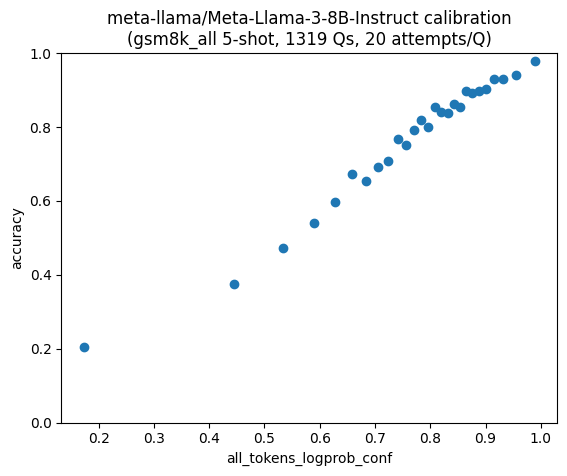

In [263]:
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=1000)

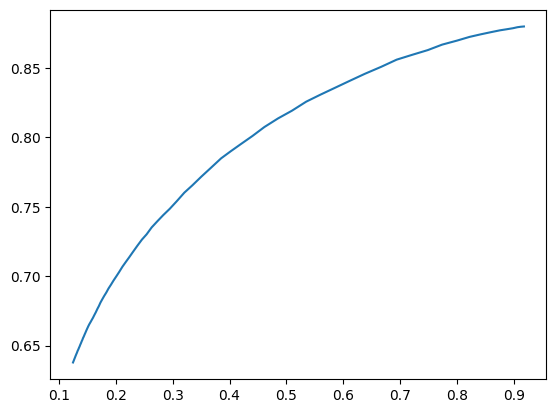

In [278]:
test = cost_acc_curve_points("all_tokens_logprob_conf", gsm8k_all_llama3_8b, None, 0.12, 0.8)
plt.plot(test['cost'], test['acc'])

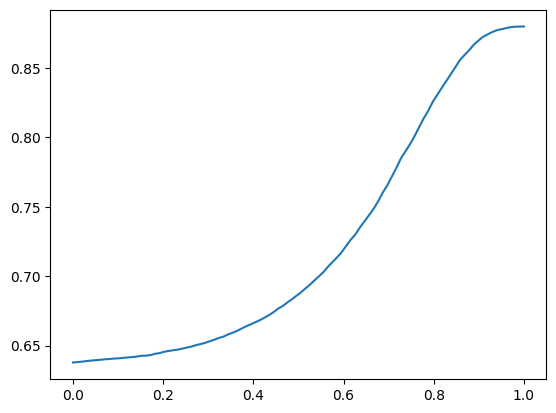

### All 70B

In [ ]:
gsm8k_all_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_70b.jsonl",
    results_file_path="results/gsm8k_all_llama3_70b.jsonl",
)
gsm8k_all_llama3_70b.write_requests_file()
# gsm8k_all_llama3_70b.read_results_file()

### Cost-Accuracy Tradeoff

### Other GSM8K

In [235]:
gsm8k_50_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=50,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_50_llama3_8b.jsonl",
    results_file_pattern="results/gsm8k_50_llama3_8b.jsonl*",
)
gsm8k_50_llama3_8b.write_requests_file()
gsm8k_50_llama3_8b.read_results_file()
gsm8k_50_llama3_8b.top1_acc()

Lines dropped: 0


100%|██████████| 1000/1000 [00:00<00:00, 151075.32it/s]


0.88

In [216]:
test = gsm8k_50_llama3_8b.get_binned("all_tokens_logprob", qa_pairs_per_bin=50)
display(test)
pw_fit = piecewise_regression.Fit(np.array(test.all_tokens_logprob), np.array(test.correct), n_breakpoints=3)
# gsm8k_50_llama3_8b.get_confs("tokens_prob")
# gsm8k_50_llama3_8b.plot_estimated_confidence_vs_accuracy("tokens_prob")

,all_tokens_logprob,correct
bin,,
0,-62.635323,0.34
1,-46.345504,0.48
2,-39.694988,0.60
3,-35.652041,0.48
4,-32.447806,0.62
5,-29.782472,0.68
6,-27.189474,0.68
7,-25.286062,0.72
8,-23.675939,0.76


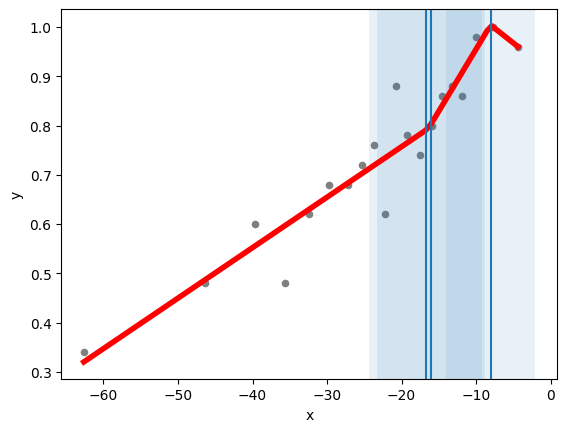

In [218]:
# pw_fit.summary()
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

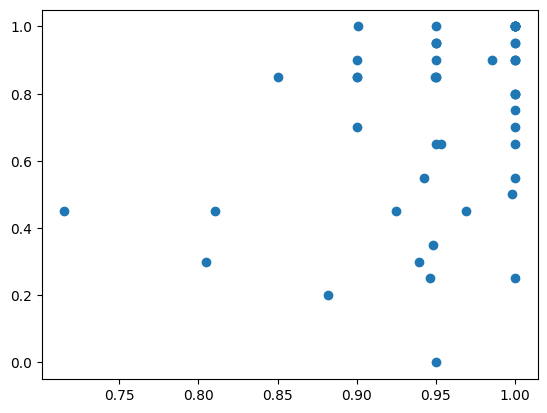

In [52]:
plt.scatter(
    gsm8k_50_llama3_8b.results[['q_id', 'tokens_prob']].groupby('q_id').mean().tokens_prob,
    gsm8k_50_llama3_8b.results[['q_id', 'correct']].groupby('q_id').mean().correct
)

In [37]:
gsm8k_50_llama3_8b.results.response.iloc[2]['choices'][0]['logprobs']['token_logprobs']

[-0.2535925805568695,
 -0.974077045917511,
 -0.07889007776975632,
 -0.2032782882452011,
 -0.4744071960449219,
 -0.4198276698589325,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.07287787614041e-05,
 -0.6931471824645996,
 0.0,
 -6.079655122448457e-06,
 -0.0019286142196506262,
 -1.0132738680113107e-05,
 -0.0025414093397557735,
 0.0,
 -2.145764938177308e-06,
 -0.10195835679769516,
 -0.00043072958942502737,
 0.0,
 0.0,
 -4.768370445162873e-07,
 -0.011594647541642189,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.1920928244535389e-07,
 0.0,
 -6.294052582234144e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -4.887569048150908e-06,
 0.0,
 0.0,
 -0.06198599189519882,
 -2.9801878554280847e-05,
 0.0,
 -1.0728830375228426e-06,
 0.0,
 -7.152531907195225e-06,
 0.0,
 0.0,
 -0.0297507643699646,
 -9.536738616588991e-07,
 0.0,
 0.0,
 -1.1324817933200393e-05,
 -0.0009274948388338089,
 -0.0005149707430973649,
 0.0,
 0.0,
 -5.1616290875244886e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.490105023549404e-05,
 0.0,
 -0.825977087020874,
 -2.0

In [178]:
gsm8k_50_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=50,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_50_llama3_70b.jsonl",
    results_file_path="results/gsm8k_50_llama3_70b.jsonl",
)
gsm8k_50_llama3_70b.write_requests_file()

In [ ]:
# gsm8k_50_llama3_70b.read_results_file()
# gsm8k_50_llama3_70b.top1_acc()

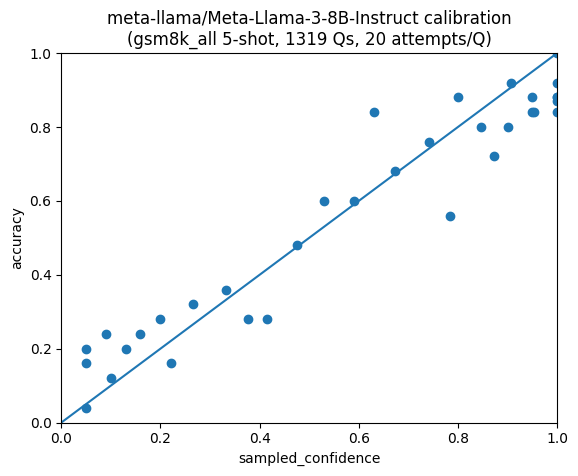

In [106]:
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy()

In [223]:
gsm8k_all_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_70b.jsonl",
    results_file_path="results/gsm8k_all_llama3_70b.jsonl",
)
gsm8k_all_llama3_70b.write_requests_file()
# gsm8k_all_llama3_70b.read_results_file()

TypeError: __init__() got an unexpected keyword argument 'results_file_path'

## MATH (1000 Qs)

In [167]:
def extract_boxed_expression(input_string):
    start_idx = input_string.find(r"\boxed{")
    if start_idx == -1:
        return None

    start_idx += len(r"\boxed{")
    brace_count = 1
    result = []

    for idx in range(start_idx, len(input_string)):
        char = input_string[idx]
        result.append(char)
        
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0:
                # We've found the closing brace for \boxed{
                return ''.join(result[:-1])  # Exclude the last closing brace
    
    return None

def get_math_df(data_path, split):
    jsons = []
    for root, dirs, files in os.walk(os.path.join(data_path, split)):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, "r") as f:
                    jsons.append(json.load(f))
    
    df = pd.DataFrame.from_dict(jsons).rename(columns={'problem': 'question', 'solution': 'answer'})
    df['q_id'] = df.index

    return df

def math_is_equiv(s1, s2):
    return boxed_answer_is_equiv(extract_boxed_expression(s1), extract_boxed_expression(s2))

def math_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer inside \\boxed{}.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

In [168]:
math_all = CalibrationDataset(
    dataset_name="math_all",
    df = get_math_df("MATH/", "test"),
    is_equiv=math_is_equiv,
    get_prompt_content=math_get_prompt_content,
    seed=SEED,
)

In [169]:
math_500q_llama3_70b = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=500,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/requests_math_llama3_70b_500q_20a.jsonl",
    results_file_path="results/results_math_llama3_70b_500q_20a.jsonl",
)

In [170]:
math_500q_llama3_70b.read_results_file()

Lines dropped: 1


100%|██████████| 9990/9990 [00:00<00:00, 112360.99it/s]


In [171]:
math_500q_llama3_70b.results.attempt.iloc[1]

'Question: If $f(x)=ax^4-bx^2+x+5$ and $f(-3)=2,$ then what is the value of $f(3)$?\n\nWe are given that $f(x)=ax^4-bx^2+x+5$ and $f(-3)=2$.  We can substitute $x=-3$ into $f(x)$ to obtain \\begin{align*}\nf(-3)&=a(-3)^4-b(-3)^2+(-3)+5\\\\\n&=81a-9b-3+5\\\\\n&=81a-9b+2.\n\\end{align*}Since we know that $f(-3)=2$, we can solve for $a$ and $b$: \\begin{align*}\n81a-9b+2&=2\\\\\n\\Rightarrow\\qquad 81a-9b&=0.\n\\end{align*}Now, we want to find the value of $f(3)$.  We have that \\begin{align*}\nf(3)&=a(3)^4-b(3)^2+(3)+5\\\\\n&=81a-9b+8.\n\\end{align*}Using the fact that $81a-9b=0$, we see that $f(3)=0+8=\\boxed{8}.$\n#### 8'

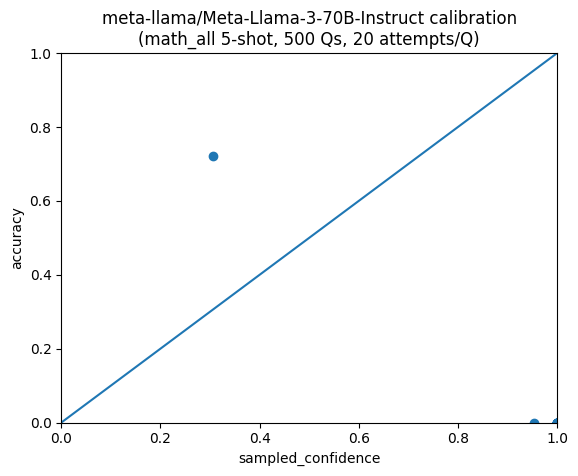

In [172]:
math_500q_llama3_70b.plot_estimated_confidence_vs_accuracy()